# VQE Energy Optimisation

We use shall demonstrate use of the Pennylane Library to construct the Disentangled UCC ansatz and perform the VQE energy optimisation on our laptops. To maintain code consistency, we will use any default values if possible. VQE will be performed on the Hydrogen Molecule $H_2$ at its known equilibrium bond length of 1.4 Bohr. For a more detailed tutorial please refer to official documentation [here](https://pennylane.ai/qml/demos/tutorial_vqe.html).

Variational Quantum Eigensolver Steps:
1. For a particular molecular geometry, get the molecular Hamiltonian $H$ using `qml.qchem.molecular_hamiltonian()`, which will act as an observable to measure the molecular energy $E$ of the quantum output state.
2. On the quatum circuit, prepare the Hartree-Fock Ground State $|\psi_{0}\rangle$.
3. Apply the Problem-Inspired Ansatz $\prod_{\alpha}U_{\alpha}(\theta_\alpha)$, Disentangled Unitary Coupled Cluster (UCC) , with initial parameters set to zero.
$$|\psi_{PI}\rangle = \prod_{\alpha}U_{\alpha}(\theta_\alpha)|\psi_0\rangle$$
4. Perform measurement to get $\langle\psi_{PI}|H|\psi_{PI}\rangle \approx E$ as the estimate of the molecular energy.
5. Feed the energy estimate $E$ into the optimiser.
6. Repeat from step 1 onwards, using new parameters from the optimiser.

In addition, we provided a [QAMUY](https://qamuy.qunasys.com/docs/en/) VQE Implementation of Hydrogen Molecule below.

### PennyLane Implementation

In [2]:
# Native Lib
import itertools as it

# External Lib
import pennylane as qml
import numpy as np
from pennylane import numpy as plnp
import matplotlib.pyplot as plt

# qanything Lib
import qanything.get_index as getind
import qanything.get_molecule as getmol
import qanything.get_json as getjson

In [3]:
# Create the Hydrogen Molecule
mol_name = 'h2'
mol_full_name = 'hydrogen molecule'
bond_length = 1.4
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length)

# Get the Molecular Hamiltonian (Using Jordan-Wigner)
mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

# Get the Orbital and Single and Double Excitation Index 
occupied_index, single_index, double_index = getind.generate_excite_index(num_qubits, num_elec)

# Get the Disentangled Unitary Coupled Cluster Single Doubles (UCCSD) Excitation Sequence 
disentangle_order = getind.generate_disentanglement_order(occupied_index, single_index, double_index)

# Get the Hartree-Fock State
hf = qml.qchem.hf_state(electrons=num_elec, orbitals=num_qubits)

# Prepare the problem-inspired ansatz based on the Disentangled Sequence
def uccsd_ansatz(params, wires, excitations):
    qml.BasisState(hf, wires=wires)
    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)

# Prepare the Statevector Device, cost function
dev = qml.device("default.qubit", wires=num_qubits)  # Statevector Device (Matrix Calculation)
cost_fn_uccsd = qml.ExpvalCost(uccsd_ansatz, mol_ham, dev, optimize=True)  # Cost Function

# Gradient Based Optimiser
max_steps = 200
optimiser_gd = qml.GradientDescentOptimizer()  

# Set Initial Parameters 
params_uccsd = plnp.zeros(len(disentangle_order), requires_grad=True)
gd_params_hist_uccsd = [params_uccsd]
gd_energy_hist_uccsd = np.zeros(max_steps)

# Perform VQE for Problem-Inspired 
for step in range(max_steps):
    params_uccsd, energy_uccsd = optimiser_gd.step_and_cost(cost_fn_uccsd, params_uccsd, excitations=disentangle_order)
    
    gd_params_hist_uccsd.append(params_uccsd)
    gd_energy_hist_uccsd[step] = energy_uccsd
    if (step+1)%10 == 0:
        print(f"Iter: {step+1}, Energy: {energy_uccsd}")
    elif step == 0:
        print(f"Iter: {step+1}, Energy: {energy_uccsd}")

/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


Iter: 1, Energy: -1.116714325063832
Iter: 10, Energy: -1.1194808918547907
Iter: 20, Energy: -1.1221246714906385
Iter: 30, Energy: -1.1243788599312177
Iter: 40, Energy: -1.126299987480848
Iter: 50, Energy: -1.1279366253161764
Iter: 60, Energy: -1.1293304382341816
Iter: 70, Energy: -1.1305171174252007
Iter: 80, Energy: -1.1315272011993793
Iter: 90, Energy: -1.132386793026507
Iter: 100, Energy: -1.1331181868036744
Iter: 110, Energy: -1.1337404092337109
Iter: 120, Energy: -1.1342696887921138
Iter: 130, Energy: -1.1347198601325967
Iter: 140, Energy: -1.1351027120375377
Iter: 150, Energy: -1.1354282862314284
Iter: 160, Energy: -1.1357051335906336
Iter: 170, Energy: -1.1359405335311883
Iter: 180, Energy: -1.136140681655625
Iter: 190, Energy: -1.1363108500988774
Iter: 200, Energy: -1.1364555244354382


### Results

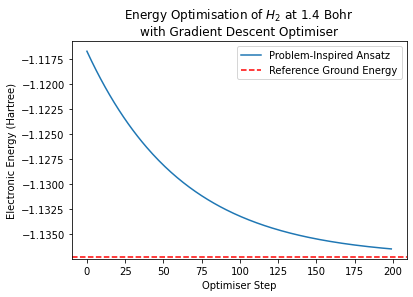

In [8]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(np.arange(0,max_steps),gd_energy_hist_uccsd, label='Problem-Inspired Ansatz')
ax.axhline(y=-1.1372759436170639, color='r', linestyle='--', label="Reference Ground Energy")
ax.set_xlabel('Optimiser Step')
ax.set_ylabel('Electronic Energy (Hartree)')
ax.set_title(r'Energy Optimisation of $H_2$ at 1.4 Bohr'+ f'\nwith Gradient Descent Optimiser')
ax.legend()

### Discussion

From the optimisation iteration graph above, we indeed see that our problem-inspired ansatz (Disentangled UCC) is capable of generating the ground state energy, as the energy converges to the reference ground energy. However, the speed of convergence is too slow for our liking as our gradient descent is too basic for our VQE. We shall attempt to find better optimisers that are available from Pennylane to improve the convergence rate. This is an important step as the number of paramters will eventually grow with bigger molecules.

### Qamuy Implementation

Currently, Qamuy does not allow user-defined custom ansatz for VQE optimisation, instead it offers several ansatz ready for VQE implementation [[1]](https://qamuy.qunasys.com/docs/en/input/ansatz.html). We shall use the currently offered single-step trotterised-UCCSD, which applies singles and doubles excitation operators once without repetition, where doubles are applied first before singles. Unfortunately, there is no way to find out the exact sequence the single and doubles are applied as Qamuy does not provide a functionality to view the quantum circuit. 

In [9]:
import qamuy.chemistry as qy
from qamuy.client import Client

In [10]:
# Create Hydrogen Molecule
mol_name = 'h2'
mol_full_name = 'hydrogen molecule'
bond_length = 0.529177249 * 1.4 # Convert to Angstroms

# Get Hydrogen Molecule
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length)
new_coords = coords.reshape((2,3)).tolist()
setting = qy.QamuyChemistryInput()
molecule = setting.target_molecule
molecule.geometry = qy.molecule_geometry(mol_symbols, new_coords)
molecule.basis = "sto-3g"
molecule.multiplicity = 1
molecule.num_excited_states = 0

# Set Fermion to Spin Mapping
setting.mapping.type = "JORDAN_WIGNER"

# Set Quantum Algorithm 
setting.solver.type = "VQE"

# Set cost function
setting.cost_function.type = "NONE"

# Set ansatz
setting.ansatz.type = "UCCSD"
setting.ansatz.trotter_steps = 1
setting.ansatz.reference_state = 'RHF'
setting.ansatz.initial_parameter = [0]
setting.ansatz.use_random_initial_guess = False

# My Optimiser
setting.optimizer.type = "BFGS"

# Quantum Device
setting.quantum_device.type = "EXACT_SIMULATOR"

# Ab Inito Calculation For Reference
setting.post_hf_methods.append(qy.PostHFMethod(type="FCI"))

In [37]:
# Submit Jobs for computation
job = client.submit(setting)
results = client.wait_and_get_job_results([job])
output = results[0].output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   26.7s finished


In [64]:
# Summary of Quantum Resources Used
print(output.molecule_result.quantum_device_result.vqe_log.quantum_resources.circuit)

{'num_qubit': 4, 'num_parameter': 3, 'num_gate': 76, 'num_1qubit_gate': 12, 'num_2qubit_gate': 64}


### Results

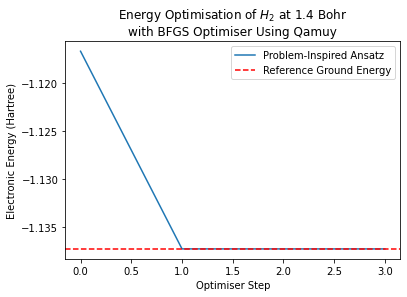

In [45]:
# Collect VQE Optimisation Results
hf_energy = output.molecule_result.hf_result.evaluated_properties[0].energy.values[0].value
ref_energy = output.molecule_result.post_hf_results[0].evaluated_properties[0].energy.values[0].value
uccsd_energy = output.molecule_result.quantum_device_result.evaluated_properties[0].energy.values[0].value
qy_energy_hist_uccsd_ = output.molecule_result.quantum_device_result.vqe_log.cost_hist[0].history
qy_energy_hist_uccsd = [hf_energy] + list(qy_energy_hist_uccsd_)
opt_steps = output.molecule_result.quantum_device_result.vqe_log.nit + 1

# Plot the results
fig2, ax2 = plt.subplots()
ax2.plot(np.arange(0,opt_steps),qy_energy_hist_uccsd, label='Problem-Inspired Ansatz')
ax2.axhline(y=uccsd_energy, color='r', linestyle='--', label="Reference Ground Energy")
ax2.set_xlabel('Optimiser Step')
ax2.set_ylabel('Electronic Energy (Hartree)')
ax2.set_title(r'Energy Optimisation of $H_2$ at 1.4 Bohr'+ f'\nwith BFGS Optimiser Using Qamuy')
ax2.legend()

### Discusion

We see a remarkable convergence to the reference ground state energy with BFGS, which is a quasi-newton gradient descent optimiser used in QAMUY. Pennylane currently do not have a built-in BFGS or any quasi-newton gradient descent optimisers and is relying on first-order gradient descent methods commonly used in Classical Neural Network Training in Maching Learning.